In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import random as rn
from IPython.display import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm
from matplotlib import pyplot as plt
from PIL import Image

import json

%matplotlib inline

In [ ]:
# 파일 불러오기
X_train = np.load('/content/drive/MyDrive/딥러닝 팀플/data/xy데이터/64/X_train_data_with_aug_64.npy')
X_val = np.load('/content/drive/MyDrive/딥러닝 팀플/data/xy데이터/64/X_val_data_with_aug_64.npy')
X_test = np.load('/content/drive/MyDrive/딥러닝 팀플/data/xy데이터/64/X_test_data_with_aug_64.npy')
Y_train = np.load('/content/drive/MyDrive/딥러닝 팀플/data/xy데이터/64/Y_train_data_with_aug_64.npy')
Y_val = np.load('/content/drive/MyDrive/딥러닝 팀플/data/xy데이터/64/Y_val_data_with_aug_64.npy')
Y_test = np.load('/content/drive/MyDrive/딥러닝 팀플/data/xy데이터/64/Y_test_data_with_aug_64.npy')

In [ ]:
print("X_train:", X_train.shape[0], "training images,", "height:", X_train.shape[1], ", width:", X_train.shape[2], ", channel:", X_train.shape[3])
print("X_val:", X_val.shape[0], "validation images,", "height:", X_val.shape[1], ", width:", X_val.shape[2], ", channel:", X_val.shape[3])
print("X_test:", X_test.shape[0], "test images,", "height:", X_test.shape[1], ", width:", X_test.shape[2], ", channel:", X_test.shape[3])
print("Y_train:", Y_train.shape[0], "training images,", Y_train.shape[1], "classes")
print("Y_val:", Y_val.shape[0], "training images,", Y_val.shape[1], "classes")
print("Y_test:", Y_test.shape[0], "test images,", Y_test.shape[1], "classes")

X_train: 3622 training images, height: 64 , width: 64 , channel: 3
X_val: 906 validation images, height: 64 , width: 64 , channel: 3
X_test: 284 test images, height: 64 , width: 64 , channel: 3
Y_train: 3622 training images, 3 classes
Y_val: 906 training images, 3 classes
Y_test: 284 test images, 3 classes


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Generator 생성

train_generator = ImageDataGenerator(rescale=1/255.0)
valid_generator = ImageDataGenerator(rescale=1/255.0)

In [ ]:
# 배치 사이즈 만큼 추출
flow_tr_gen = train_generator.flow(X_train, Y_train, batch_size=16, shuffle=True) # 훈련은 랜덤으로 추출
flow_val_gen = valid_generator.flow(X_val, Y_val, batch_size=16, shuffle=False) # 검증 또는 테스트는 순차적으로 추출

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler

In [ ]:
from tensorflow.keras.applications import VGG16

IMAGE_SIZE = 64

base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights=None, include_top=True)
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [ ]:
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights=None, include_top=False)
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

매 에포크마다 모델저장을 따로해서 얼리스타핑보다 더 정확하게 끊으려고 했습니다(실제로 test accuracy 상승)

In [ ]:
# vgg16
# pretrain weight 사용

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet', include_top=False)
bm_output = base_model.output

x = GlobalAveragePooling2D()(bm_output)
x = Dropout(rate=0.2)(x)
x = Dense(200, activation='relu', name='fc1')(x)
x = Dropout(rate=0.2)(x)

output = Dense(3, activation='softmax', name='output')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# 5번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
ely = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

model_checkpoint = ModelCheckpoint(filepath='model_checkpoint_epoch_{epoch:02d}_val_loss_{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='min',
                                   verbose=1,
                                   save_freq='epoch')  # Use 'epoch' to save every epoch

history = model.fit(flow_tr_gen, epochs=50, validation_data=flow_val_gen, callbacks=[rlr, ely, model_checkpoint])


58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/50
227/227 [==============================] - ETA: 0s - loss: 1.0839 - accuracy: 0.4117
Epoch 1: val_loss improved from inf to 1.05929, saving model to model_checkpoint_epoch_01_val_loss_1.0593.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


227/227 [==============================] - 27s 49ms/step - loss: 1.0839 - accuracy: 0.4117 - val_loss: 1.0593 - val_accuracy: 0.3664 - lr: 1.0000e-04
Epoch 2/50
227/227 [==============================] - ETA: 0s - loss: 1.0380 - accuracy: 0.4467
Epoch 2: val_loss improved from 1.05929 to 0.98033, saving model to model_checkpoint_epoch_02_val_loss_0.9803.h5
227/227 [==============================] - 9s 39ms/step - loss: 1.0380 - accuracy: 0.4467 - val_loss: 0.9803 - val_accuracy: 0.4404 - lr: 1.0000e-04
Epoch 3/50
227/227 [==============================] - ETA: 0s - loss: 0.9593 - accuracy: 0.5323
Epoch 3: val_loss improved from 0.98033 to 0.86829, saving model to model_checkpoint_epoch_03_val_loss_0.8683.h5
227/227 [==============================] - 9s 40ms/step - loss: 0.9593 - accuracy: 0.5323 - val_loss: 0.8683 - val_accuracy: 0.5938 - lr: 1.0000e-04
Epoch 4/50
227/227 [==============================] - ETA: 0s - loss: 0.8361 - accuracy: 0.5922
Epoch 4: val_loss improved from 0.8682

성능 보여주는 코드

9/9 [==============================] - 1s 72ms/step - loss: 110.9997 - accuracy: 0.7254
Test Accuracy: 72.54%
9/9 [==============================] - 0s 13ms/step
Confusion Matrix:
[[91 26  4]
 [22 76  7]
 [ 1 18 39]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.75      0.77       121
           1       0.63      0.72      0.68       105
           2       0.78      0.67      0.72        58

    accuracy                           0.73       284
   macro avg       0.74      0.72      0.72       284
weighted avg       0.73      0.73      0.73       284



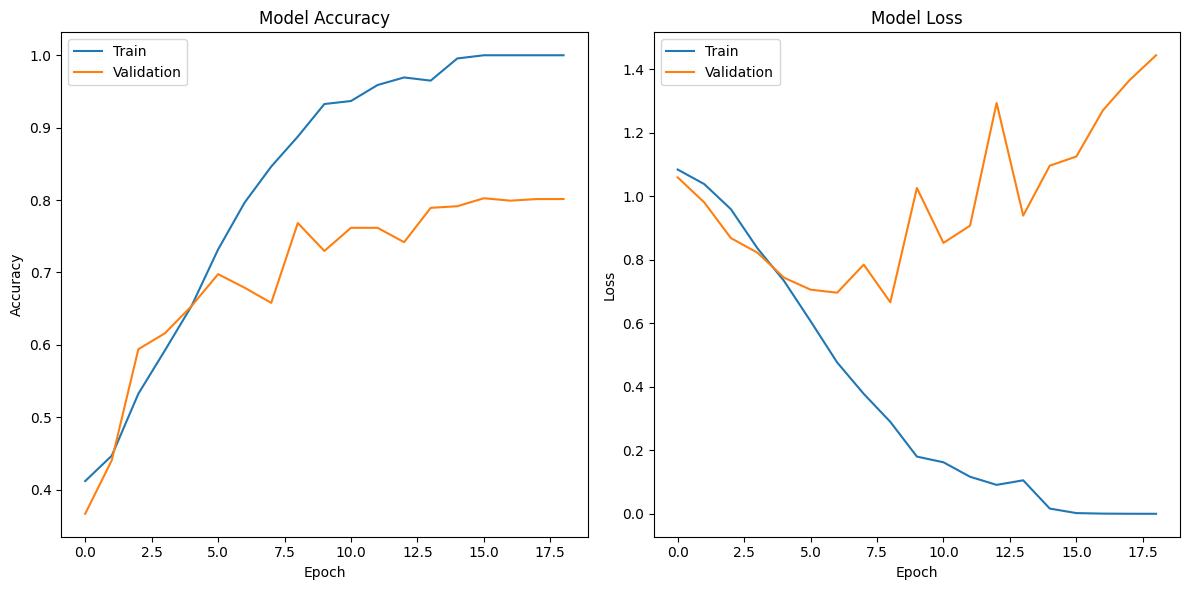

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, Y_test)
print(f'Test Accuracy: {test_acc*100:.2f}%')

predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = np.argmax(Y_test, axis=1)

conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(class_report)

# Plotting the training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


위에 그래프를 보면 에포크 9 쯤부터 과적합 의심

성능 시각화 코드

1/1 [==============================] - 0s 43ms/step


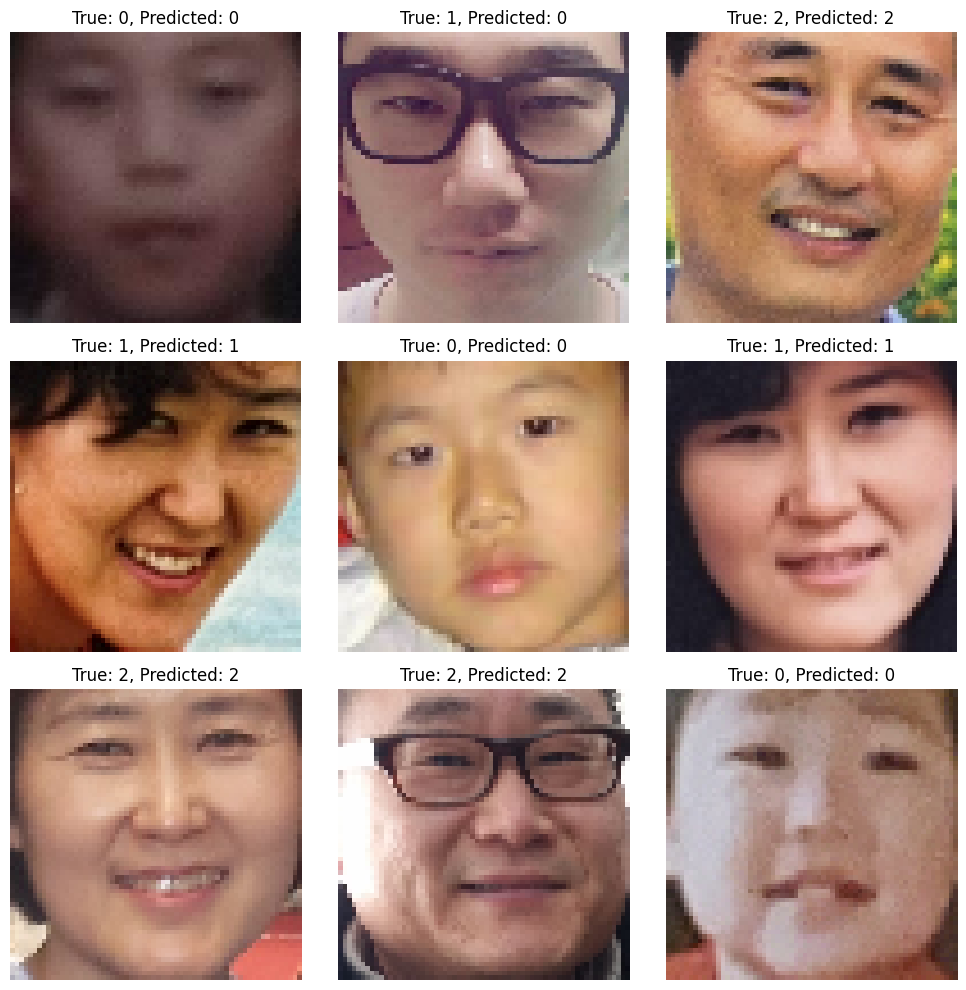

In [ ]:
import random

num_rows = 3
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

random_indices = random.sample(range(len(X_test)), num_rows * num_cols)

for i, idx in enumerate(random_indices):
    row_idx = i // num_cols
    col_idx = i % num_cols

    img = X_test[idx]
    img = np.expand_dims(img, axis=0)

    true_label = np.argmax(Y_test[idx])
    predicted_label = np.argmax(model.predict(img))


    axes[row_idx, col_idx].imshow(img.squeeze())
    axes[row_idx, col_idx].set_title(f'True: {true_label}, Predicted: {predicted_label}')
    axes[row_idx, col_idx].axis('off')


plt.tight_layout()
plt.show()


In [ ]:
model.save('vgg16_aug_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


에포크 9 모델이 75.70으로 정확도 더 높음

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


loaded_model = load_model('model_checkpoint_epoch_09_val_loss_0.6661.h5')


y_pred = loaded_model.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(Y_test, axis=1)


accuracy = accuracy_score(y_true_classes, y_pred_classes)

print(f'Test Accuracy: {accuracy * 100:.2f}%')

num_rows = 3
num_cols = 3
random_indices = np.random.choice(len(X_test), size=num_rows * num_cols, replace=False)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

for i, idx in enumerate(random_indices):
    row_idx = i // num_cols
    col_idx = i % num_cols

    img = X_test[idx]
    true_label = np.argmax(Y_test[idx])
    predicted_label = y_pred_classes[idx]

    axes[row_idx, col_idx].imshow(img)
    axes[row_idx, col_idx].set_title(f'True: {true_label}, Predicted: {predicted_label}')
    axes[row_idx, col_idx].axis('off')

plt.tight_layout()
plt.show()


NameError: ignored